In [1]:
# Classical
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# PyTorch
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch import optim

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = 15, 7

In [2]:
data = pd.read_csv('./data/digit-recognizer/train.csv')
data = np.array(data)

In [3]:
class MNIST(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __getitem__(self, index):
        X = data[index][1:]
        y = data[index][0]
        return (torch.from_numpy(X).float()/256, 
                torch.LongTensor(np.array([y])))
    
    def __len__(self):
        return len(self.data)

In [4]:
class SimpleNeuralNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.linears = nn.ModuleList([
            nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)
        ])
        
    def forward(self, x):
        for lin in self.linears:
            lin_x = lin(x)
            x = F.relu(lin_x)
        return F.log_softmax(lin_x, dim=1)

In [5]:
def init_net():
    return SimpleNeuralNet([IMAGE_SIZE, 100, 100, 10])

In [6]:
mnist = MNIST(data)
data_dl = DataLoader(mnist, batch_size = 256, shuffle=True, num_workers=0)

In [7]:
epochs = 3
criterion = nn.NLLLoss()

In [8]:
## Create architecture
IMAGE_SIZE = 28 * 28
net = init_net()

# Weight/biases
wbs = [(lin.weight, lin.bias) for lin in net.linears]
losses = []
lr = 1e-2

In [9]:
print("[Epoch, Loss]")
for epoch in range(epochs):
    for i, batch in enumerate(data_dl):
        inputs, labels = Variable(batch[0]), Variable(batch[1])
        outputs = net(inputs)
        
        loss = criterion(outputs, labels.squeeze(-1))
        losses.append(loss)
        loss.backward()
        
        for w, b in wbs:
            w.data -= lr * w.grad.data
            b.data -= lr * b.grad.data
            w.grad.data.zero_()
            b.grad.data.zero_()
    print("[{}, {}]".format(epoch, loss.data[0]))

[Epoch, Loss]
[0, 2.2686562538146973]
[1, 2.145275831222534]
[2, 1.9207435846328735]


In [10]:
sgd_losses = [(l.data.numpy()[0]) for l in losses]
sgd_log_losses_ = [np.log(l) for l in sgd_losses]

Text(0.5,1,'Vanilla SGD')

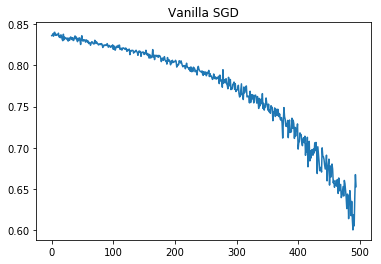

In [11]:
plt.plot(sgd_log_losses_)
plt.title("Vanilla SGD")

## Adding momentum

We can greatly improve neural net performance by reducing variance in the gradient.
We do so through a linear interpolocation between past gradients and the current one.

Implementation is inspired by PyTorch's `optim.SGD` docstring:
```
        .. math::
                  v = \rho * v + g \\
                  p = p - lr * v

        where p, g, v and :math:`\rho` denote the parameters, gradient,
        velocity, and momentum respectively.
```

In [18]:
net = init_net()
wbs = [(lin.weight, lin.bias) for lin in net.linears]
losses = []

# parameters
lr = 1e-3
rho = .9
epochs = 3

# momentum trackers
weight_v_prev = [0 for i in range(len(wbs))]
bias_v_prev = [0 for i in range(len(wbs))]

In [15]:
### Training 
for epoch in range(epochs):
    print(f'epoch {epoch}')
    for i, batch in enumerate(data_dl):
        inputs, labels = batch
        inputs, labels = Variable(inputs), Variable(labels)
        outputs = net(inputs)
        
        # compute loss and gradients
        loss = criterion(outputs, labels.squeeze(-1))
        losses.append(loss)
        loss.backward()
        
        # update weights 
        for i, wb in enumerate(wbs):
            w = wb[0]
            b = wb[1]
            weight_v_new = rho*weight_v_prev[i] + lr*w.grad.data
            bias_v_new = rho*bias_v_prev[i] + lr*b.grad.data
            
            weight_v_prev[i] = weight_v_new
            bias_v_prev[i] = bias_v_new
            
            w.data -= weight_v_new
            b.data -= bias_v_new
            
            # zero the gradients
            w.grad.data.zero_()
            b.grad.data.zero_()

epoch 0
epoch 1
epoch 2


In [ ]:
print("[Epoch, Loss]")
for epoch in range(epochs):
    for i, batch in enumerate(data_dl):
        inputs, labels = Variable(batch[0]), Variable(batch[1])
        outputs = net(inputs)
        
        loss = criterion(outputs, labels.squeeze(-1))
        losses.append(loss)
        loss.backward()
        
        for i, wb in enumerate(wbs):
            w = wb[0]
            b = wb[1]
            weight_v_curr = rho * weight_v_prev[i] + lr * w.grad.data
            bias_v_curr = rho * bias_v_prev[i] + lr * b.grad.data
            
            weight_v_prev[i] = weight_v_curr
            bias_v_prev[i] = bias_v_curr
            w.data -= weight_v_curr
            b.data -= bias_v_curr
            
            w.grad.data.zero_()
            b.grad.data.zero_()
    print("[{}, {}]".format(epoch, loss.data[0]))

[Epoch, Loss]


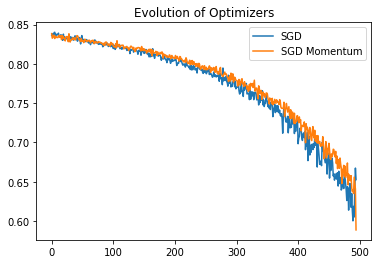

In [16]:
sgdmom_losses_ = [(l.data.numpy()[0]) for l in losses]
sgdmom_log_losses_ = [np.log(l) for l in sgdmom_losses_]

plt.plot(sgd_log_losses_)
plt.plot(sgdmom_log_losses_)
title = plt.title("Evolution of Optimizers")
plt.legend(('SGD', 'SGD Momentum'))   